In [3]:
import pickle

def count_records(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data.shape

train_total = count_records('data/next-day-wildfire-spread/train.data')
val_total = count_records('data/next-day-wildfire-spread/validation.data')
test_total = count_records('data/next-day-wildfire-spread/test.data')

total_records = train_total + val_total + test_total

print(f"Train records (raw):     {train_total}")
print(f"Validation records (raw):{val_total}")
print(f"Test records (raw):      {test_total}")
print(f"Total records (raw):     {total_records}")


Train records (raw):     (28000, 19, 64, 64)
Validation records (raw):(5333, 19, 64, 64)
Test records (raw):      (6000, 19, 64, 64)
Total records (raw):     (28000, 19, 64, 64, 5333, 19, 64, 64, 6000, 19, 64, 64)


In [4]:
!pip install plotly

     |████████████████████████████████| 9.8 MB 21.3 MB/s            
     |████████████████████████████████| 392 kB 120.7 MB/s            
You should consider upgrading via the '/cs/student/projects2/aisd/2024/pallavi/msc_main_project/venv/bin/python3 -m pip install --upgrade pip' command.


In [5]:
print(f"Total records (raw):     {total_records[0]} rows, {total_records[1]} columns")
print(f"Total records (raw):     {total_records[0] * total_records[1]} total entries")
print(f"Total records (raw):     {total_records[0]} rows, {total_records[1]} columns, {total_records[0] * total_records[1]} total entries")


Total records (raw):     28000 rows, 19 columns
Total records (raw):     532000 total entries
Total records (raw):     28000 rows, 19 columns, 532000 total entries


In [6]:
import pickle
import numpy as np

def check_shape(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    

    if isinstance(data, np.ndarray):
        print(f"{file_path} → shape: {data.shape}")
        return data.shape
    elif isinstance(data, (list, tuple)):
        print(f"{file_path} → contains {len(data)} elements. First element shape: {np.array(data[0]).shape}")
        return len(data), np.array(data[0]).shape
    else:
        print(f"{file_path} → Unknown data type: {type(data)}")
        return None

train_shape = check_shape('data/next-day-wildfire-spread/train.data')
val_shape = check_shape('data/next-day-wildfire-spread/validation.data')
test_shape = check_shape('data/next-day-wildfire-spread/test.data')


data/next-day-wildfire-spread/train.data → shape: (28000, 19, 64, 64)
data/next-day-wildfire-spread/validation.data → shape: (5333, 19, 64, 64)
data/next-day-wildfire-spread/test.data → shape: (6000, 19, 64, 64)


DataFrame built with 500,000 rows | Fire=1: 7,080, No-Fire=0: 492,920 | ratio (1:0) = 0.014363


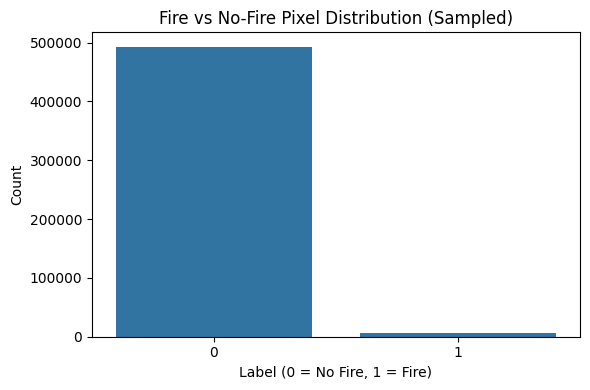

In [7]:
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load function ---
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# --- Load data ---
train_data   = load_pickle('data/next-day-wildfire-spread/train.data')    # (N, C, 64, 64)
train_labels = load_pickle('data/next-day-wildfire-spread/train.labels')  # (N, 64, 64)

# --- Feature names (will be trimmed if channels < names) ---
feature_names = [
    'elevation','fws','population','pdsi','pr','sph','slope','PrevFireMask',
    'erc','NDVI','fpr','ftemp','th','EVI','vs','tmmx','fwd','aspect','tmmn'
]

def build_df_for_eda(data, labels, feature_names, max_rows=500_000, seed=42,
                     oversample_fire=False, fire_target=0.20):
    """
    Build a pixel-level DataFrame without materializing the full (N*64*64, C).
    - Samples up to max_rows valid pixels (labels != -1).
    - Optionally oversamples fire pixels to reach fire_target proportion.
    Returns a pandas DataFrame with columns feature_names + 'Fire'.
    """
    rng = np.random.default_rng(seed)
    N, C, H, W = data.shape

    # Make sure feature_names matches channel count
    if len(feature_names) != C:
        feature_names = feature_names[:C]

    # 1) Valid pixel indices (exclude -1)
    labels_flat = labels.reshape(-1)
    valid_idx = np.where(labels_flat != -1)[0]
    if valid_idx.size == 0:
        raise ValueError("No valid labels (all are -1).")

    # 2) Choose which valid pixels to sample
    if not oversample_fire:
        k = min(max_rows, valid_idx.size)
        sel = rng.choice(valid_idx, size=k, replace=False)
    else:
        # Stratified sample to increase % of fire pixels in the sample
        y_valid = labels_flat[valid_idx]
        ones_idx  = valid_idx[y_valid == 1]
        zeros_idx = valid_idx[y_valid == 0]

        k = min(max_rows, valid_idx.size)
        k_ones  = min(len(ones_idx), int(k * fire_target))
        k_zeros = min(len(zeros_idx), k - k_ones)

        sel_parts = []
        if k_ones > 0:  sel_parts.append(rng.choice(ones_idx,  size=k_ones,  replace=False))
        if k_zeros > 0: sel_parts.append(rng.choice(zeros_idx, size=k_zeros, replace=False))

        sel = np.concatenate(sel_parts) if sel_parts else np.array([], dtype=valid_idx.dtype)
        if sel.size < k:
            remaining = np.setdiff1d(valid_idx, sel, assume_unique=False)
            top_up = rng.choice(remaining, size=k - sel.size, replace=False)
            sel = np.concatenate([sel, top_up])
        rng.shuffle(sel)

    # 3) Map flat indices -> (n, y, x)
    n_idx, y_idx, x_idx = np.unravel_index(sel, (N, H, W))

    # 4) Gather features and labels for sampled pixels
    X = data[n_idx, :, y_idx, x_idx].astype(np.float32, copy=False)  # (k, C)
    y = labels[n_idx, y_idx, x_idx].astype(np.int8, copy=False)      # (k,)

    # 5) Build the DataFrame used later in your EDA
    df = pd.DataFrame(X, columns=feature_names)
    df['Fire'] = y

    zeros = int((y == 0).sum())
    ones  = int((y == 1).sum())
    print(f"DataFrame built with {len(df):,} rows | Fire=1: {ones:,}, No-Fire=0: {zeros:,} | ratio (1:0) = {ones / max(1, zeros):.6f}")
    return df

# ---- Build df safely (natural distribution) ----
df = build_df_for_eda(
    train_data, train_labels, feature_names,
    max_rows=500_000,         # increase if you have more RAM
    seed=42,
    oversample_fire=False     # set True if you want more fire pixels for EDA
)

# ---- Plot: Fire vs No-Fire Distribution (lightweight) ----
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Fire'].astype(int))
plt.title("Fire vs No-Fire Pixel Distribution (Sampled)")
plt.xlabel("Label (0 = No Fire, 1 = Fire)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:
num_zeros = (df['Fire'] == 0).sum()
num_ones = (df['Fire'] == 1).sum()

In [9]:
print(num_ones/num_zeros)

# Calculate ratio
if num_ones != 0:
    ratio = num_zeros / num_ones
    print(f"Ratio of 0s to 1s: {ratio:.3f} ({num_zeros}:{num_ones})")
else:
    print("No 1s found in the labels.")

0.014363385539235576
Ratio of 0s to 1s: 69.621 (492920:7080)


In [20]:
import numpy as np
import pandas as pd

def build_df_for_eda(data, labels, feature_names=None, sample_size=500_000, seed=42):
    """
    Create a pixel-level DataFrame from wildfire dataset without blowing memory.
    
    data: numpy array (N, C, H, W)
    labels: numpy array (N, H, W) with -1 for invalid pixels
    feature_names: list of C feature names, or None to auto-name
    sample_size: number of pixels to sample for EDA
    """
    rng = np.random.default_rng(seed)
    N, C, H, W = data.shape

    # Handle feature names robustly
    if feature_names is None:
        feature_names = [f"feat_{i}" for i in range(C)]
    else:
        feature_names = list(feature_names)
        if len(feature_names) < C:
            # pad with auto names
            feature_names += [f"feat_{i}" for i in range(len(feature_names), C)]
        elif len(feature_names) > C:
            # trim extra names
            feature_names = feature_names[:C]

    # Mask out invalid labels (-1)
    labels_flat = labels.reshape(-1)
    valid_idx = np.where(labels_flat != -1)[0]

    # Randomly choose pixels to sample
    sample_size = min(sample_size, len(valid_idx))
    if sample_size == 0:
        raise ValueError("No valid pixels found (all labels == -1).")

    chosen_idx = rng.choice(valid_idx, size=sample_size, replace=False)

    # Convert flat index → (n, y, x)
    n_idx, y_idx, x_idx = np.unravel_index(chosen_idx, (N, H, W))

    # Gather sampled features and labels
    X = data[n_idx, :, y_idx, x_idx]  # shape: (sample_size, C)
    y = labels[n_idx, y_idx, x_idx]

    # Create DataFrame
    df = pd.DataFrame(X, columns=feature_names)
    df["Fire"] = y.astype(int)

    print(f"DataFrame created with {len(df):,} pixels sampled from {len(valid_idx):,} valid pixels across {C} features.")
    return df


In [22]:
train_data = np.load('data/next-day-wildfire-spread/train.data', allow_pickle=True)
train_labels = np.load('data/next-day-wildfire-spread/train.labels', allow_pickle=True)

feature_names = [
    'elevation','fws','population','pdsi','pr','sph','slope','PrevFireMask',
    'erc','NDVI','fpr','ftemp','th','EVI','vs','tmmx','fwd','aspect','tmmn'
]

df = build_df_for_eda(train_data, train_labels, feature_names=feature_names, sample_size=500_000)


DataFrame created with 500,000 pixels sampled from 113,838,405 valid pixels across 19 features.


In [23]:
print(train_data.shape)  # Should show (num_samples, 19, 64, 64)
print(len(feature_names))  # Should be 19


(28000, 19, 64, 64)
19


In [24]:
feature_names

['elevation',
 'fws',
 'population',
 'pdsi',
 'pr',
 'sph',
 'slope',
 'PrevFireMask',
 'erc',
 'NDVI',
 'fpr',
 'ftemp',
 'th',
 'EVI',
 'vs',
 'tmmx',
 'fwd',
 'aspect',
 'tmmn']

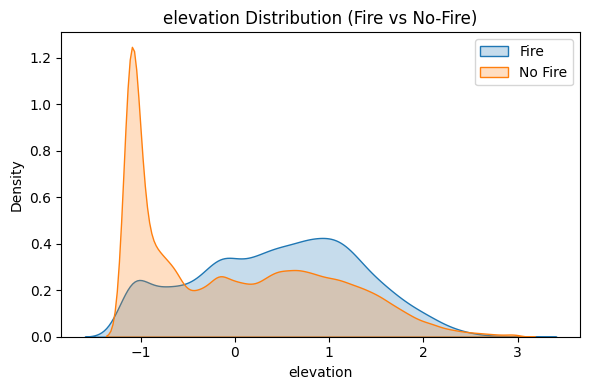

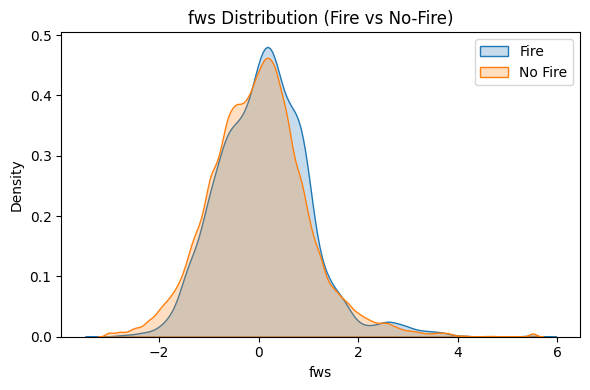

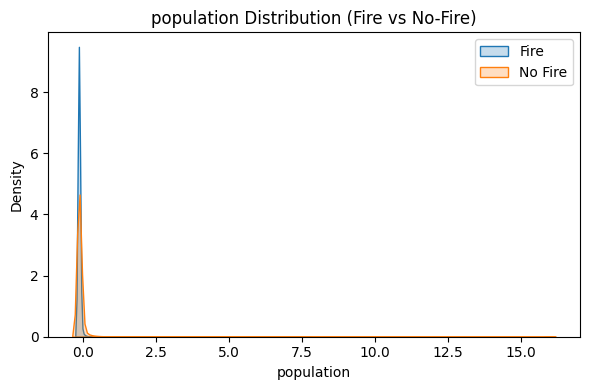

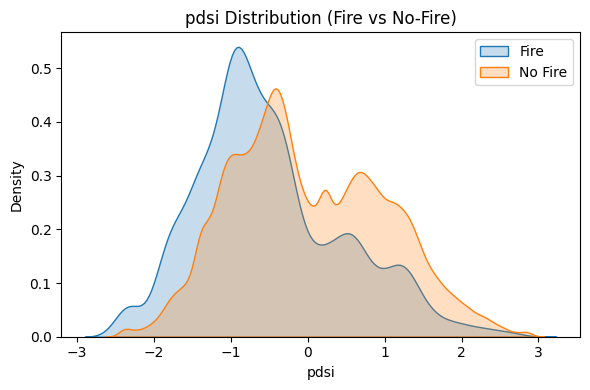

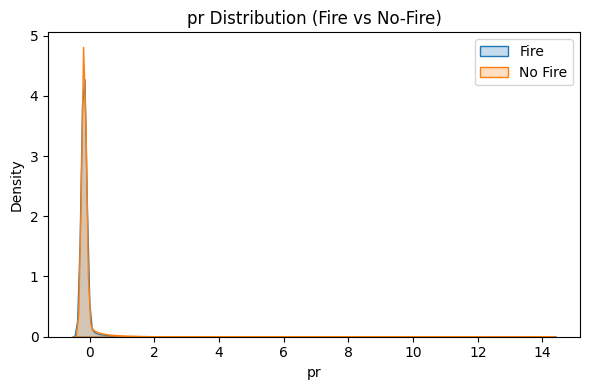

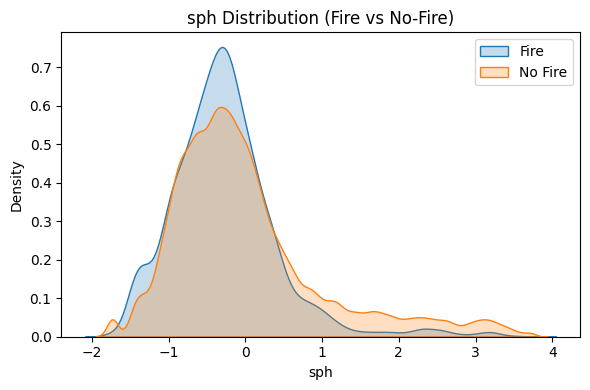

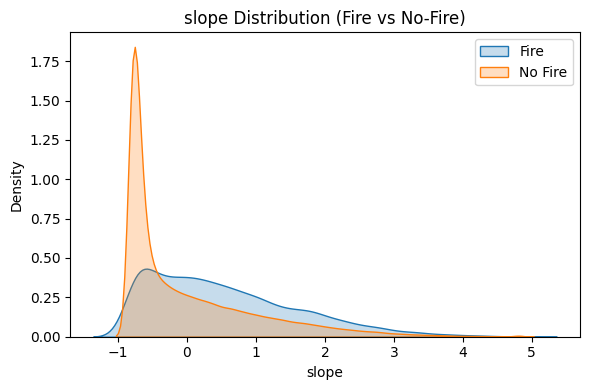

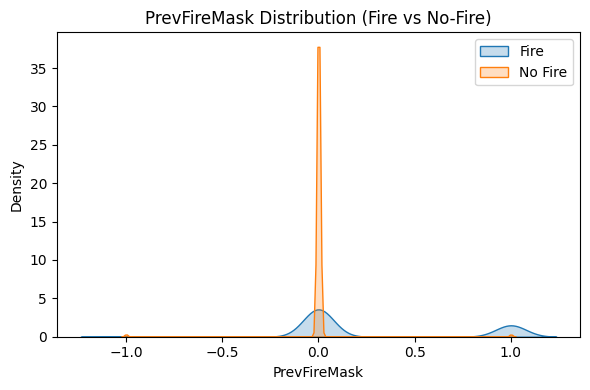

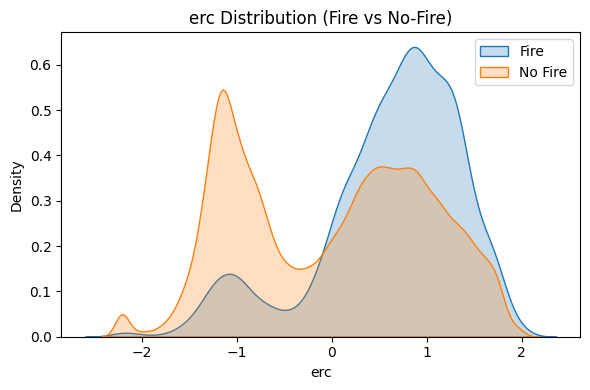

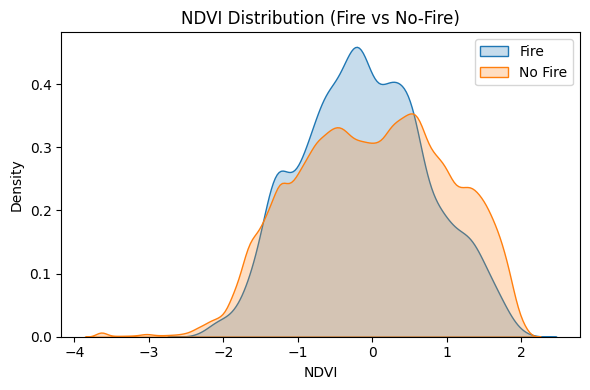

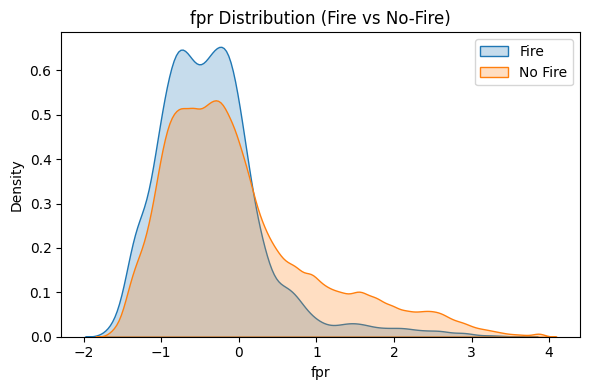

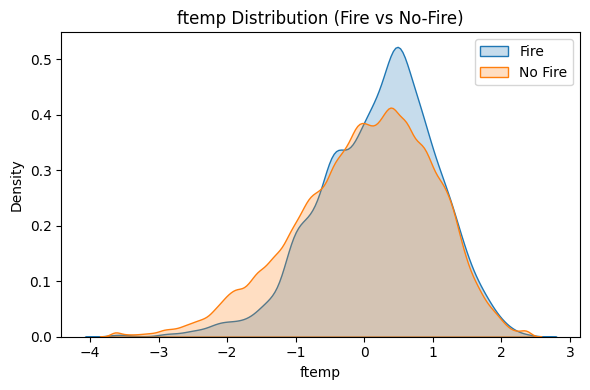

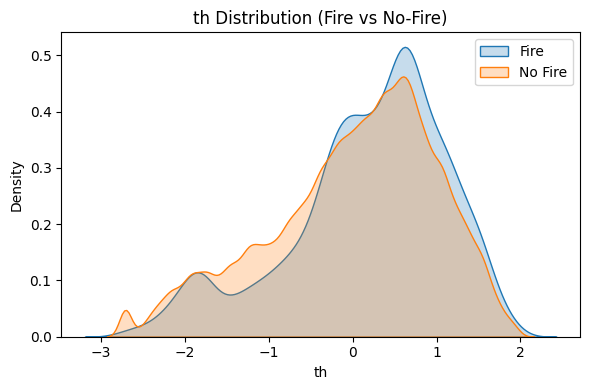

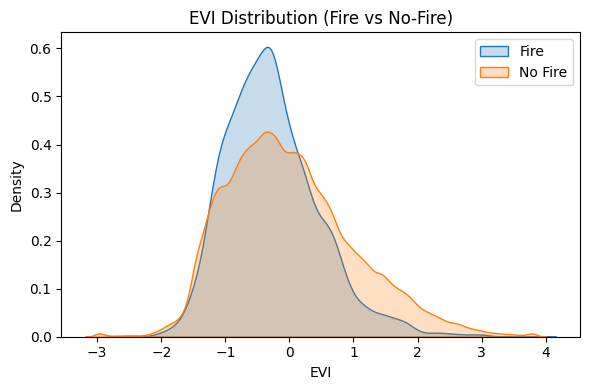

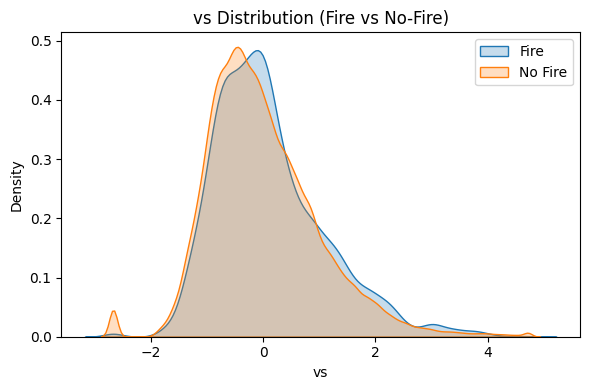

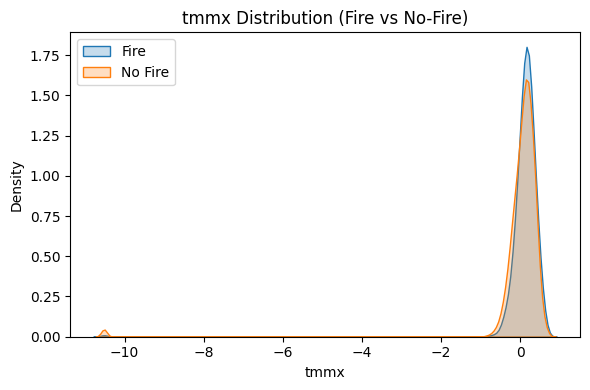

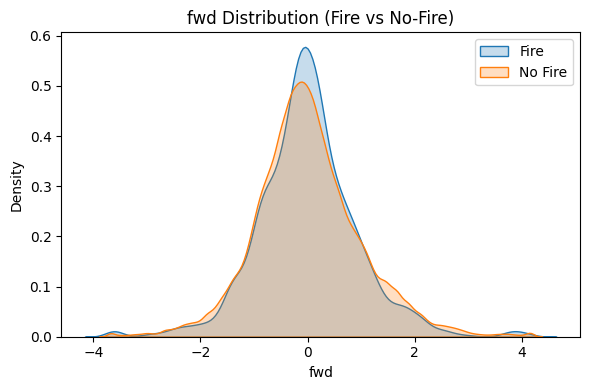

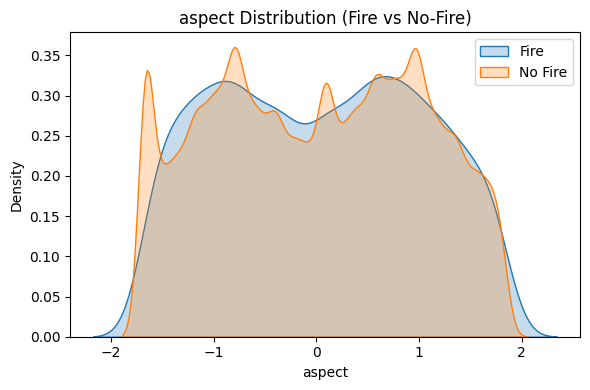

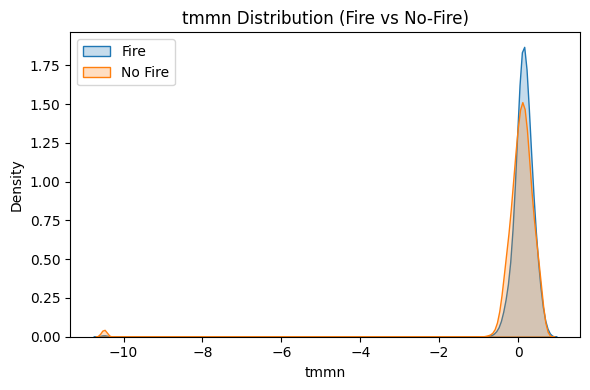

In [25]:

# 2. KDE plots for each feature
for feat in feature_names:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df[df['Fire'] == 1], x=feat, label='Fire', fill=True, common_norm=False)
    sns.kdeplot(data=df[df['Fire'] == 0], x=feat, label='No Fire', fill=True, common_norm=False)
    plt.title(f'{feat} Distribution (Fire vs No-Fire)')
    plt.legend()
    plt.tight_layout()
    plt.show()



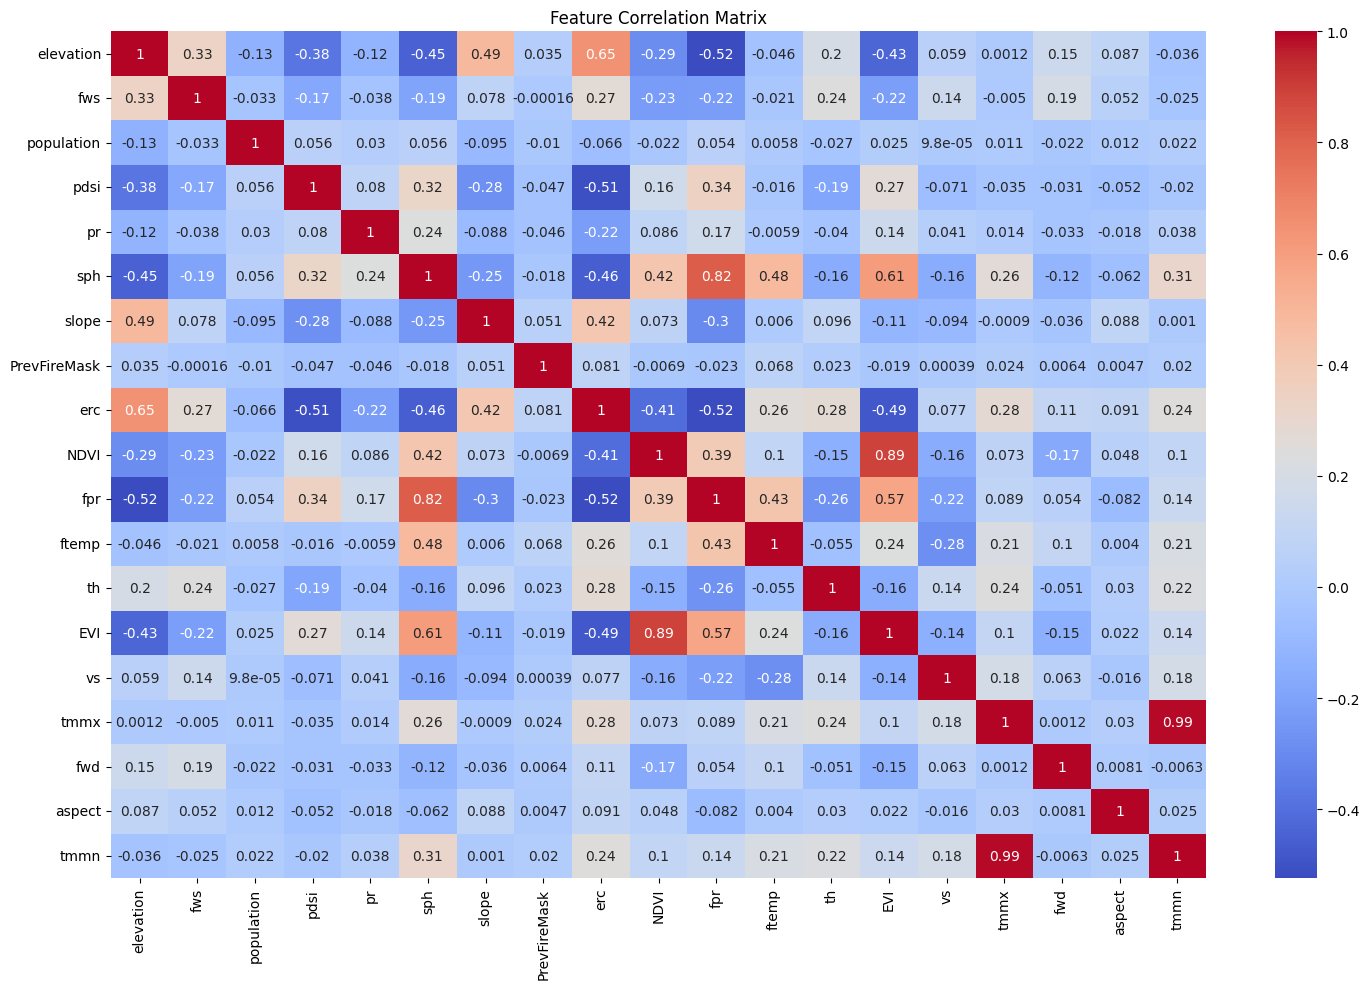

In [28]:
# 3. Correlation Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df[feature_names].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()



In [30]:
# 4. T-test

from scipy.stats import ttest_ind

print("T-Test between Fire and No-Fire pixels:\n")
for feat in feature_names:
    fire_vals = df[df['Fire'] == 1][feat]
    nofire_vals = df[df['Fire'] == 0][feat]
    t_stat, p_val = ttest_ind(fire_vals, nofire_vals, equal_var=False)
    print(f"{feat:15s} | t = {t_stat:.3f}, p = {p_val:.3e}")



T-Test between Fire and No-Fire pixels:

elevation       | t = 43.383, p = 0.000e+00
fws             | t = 10.145, p = 5.036e-24
population      | t = -41.365, p = 0.000e+00
pdsi            | t = -44.112, p = 0.000e+00
pr              | t = -20.979, p = 3.800e-95
sph             | t = -32.339, p = 6.806e-215
slope           | t = 43.046, p = 0.000e+00
PrevFireMask    | t = 52.640, p = 0.000e+00
erc             | t = 67.049, p = 0.000e+00
NDVI            | t = -11.501, p = 2.370e-30
fpr             | t = -43.402, p = 0.000e+00
ftemp           | t = 18.804, p = 4.421e-77
th              | t = 15.421, p = 7.983e-53
EVI             | t = -31.219, p = 3.292e-201
vs              | t = 9.302, p = 1.797e-20
tmmx            | t = 17.740, p = 4.652e-69
fwd             | t = -0.380, p = 7.037e-01
aspect          | t = 2.721, p = 6.522e-03
tmmn            | t = 17.867, p = 5.204e-70


In [33]:
# 5. Mutual Information

from sklearn.metrics import mutual_info_score
print("\nMutual Information between each feature and Fire label:\n")
for feat in feature_names:
    mi = mutual_info_score(df['Fire'], pd.qcut(df[feat], q=10, duplicates='drop'))
    print(f"{feat:15s} | MI = {mi:.4f}")





Mutual Information between each feature and Fire label:

elevation       | MI = 0.0024
fws             | MI = 0.0002
population      | MI = 0.0013
pdsi            | MI = 0.0020
pr              | MI = 0.0002
sph             | MI = 0.0009
slope           | MI = 0.0032
PrevFireMask    | MI = 0.0111
erc             | MI = 0.0033
NDVI            | MI = 0.0007
fpr             | MI = 0.0013
ftemp           | MI = 0.0005
th              | MI = 0.0003
EVI             | MI = 0.0012
vs              | MI = 0.0002
tmmx            | MI = 0.0005
fwd             | MI = 0.0002
aspect          | MI = 0.0001
tmmn            | MI = 0.0008


In [38]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

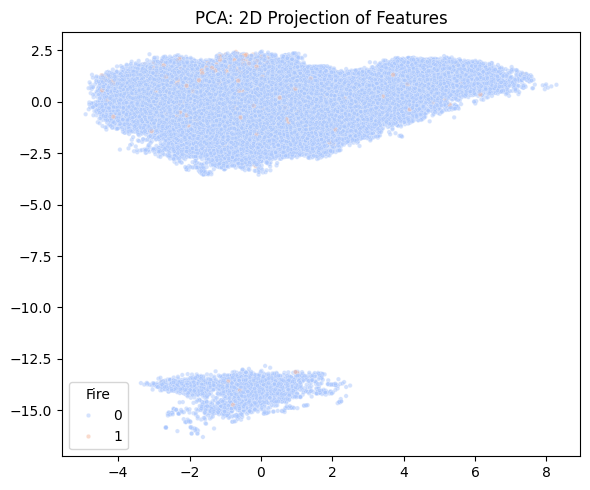

In [39]:
# 6. PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[feature_names])
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['Fire'], palette='coolwarm', s=10, alpha=0.5)
plt.title("PCA: 2D Projection of Features")
plt.tight_layout()
plt.show()



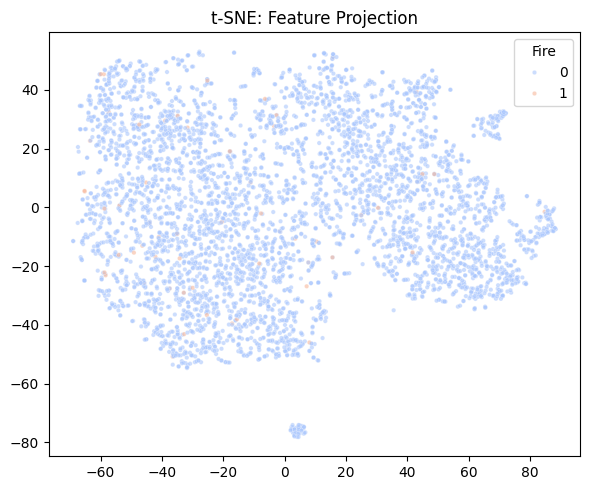

In [40]:
# 7. t-SNE
sample_df = df.sample(n=5000, random_state=42)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(sample_df[feature_names])
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=sample_df['Fire'], palette='coolwarm', s=10, alpha=0.6)
plt.title("t-SNE: Feature Projection")
plt.tight_layout()
plt.show()

In [41]:
# wildfire_exploration.py
import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import WildfireDataset, RotatedWildfireDataset
from trainModel import create_data_loaders, DATASET_PATH



In [42]:
# --------------------
# Load one full split
# --------------------
data_loaders = create_data_loaders(rank=0, gpu=0, world_size=1)
train_loader = data_loaders['train']
val_loader = data_loaders['validation']



data size: 8716288000
label size: 458752000
crop_map size: 448000
good_indices size: 172672
total size: 9175660672
finished initializing RotatedWildfireDataset
data size: 1660141568
label size: 87375872
crop_map size: 85328
good_indices size: 33568
total size: 1747636336
finished initializing WildfireDataset


<function torch.utils.data._utils.collate.default_collate(batch)>

In [43]:
# Flatten all batches into a big tensor for analysis
def collect_dataset(loader):
    all_features = []
    all_labels = []
    for images, labels in loader:
        # images: [B, C, H, W]
        # labels: [B, 1, H, W]
        all_features.append(images.numpy())
        all_labels.append(labels.numpy())
    return np.concatenate(all_features, axis=0), np.concatenate(all_labels, axis=0)

X_train, y_train = collect_dataset(train_loader)
X_val, y_val = collect_dataset(val_loader)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}")
# Example: (N, 19, 64, 64)

# --------------------
# 1. Class balance
# --------------------


/cs/student/projects2/aisd/2024/pallavi/msc_main_project/venv/lib64/python3.9/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/cs/student/projects2/aisd/2024/pallavi/msc_main_project/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be

Unexpected exception formatting exception. Falling back to standard exception


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 Traceback (most recent call last):
  File "/cs/student/projects2/aisd/2024/pallavi/msc_main_project/venv/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_362418/1406003047.py", line 12, in <module>
    X_train, y_train = collect_dataset(train_loader)
  File "/tmp/ipykernel_362418/1406003047.py", line 5, in collect_dataset
    for images, labels in loader:
  File "/cs/student/projects2/aisd/2024/pallavi/msc_main_project/venv/lib64/python3.9/site-packages/torch/utils/data/dataloader.py", line 733, in __next__
    data = self._next_data()
  File "/cs/

In [ ]:
fire_pixels = np.sum(y_train)
no_fire_pixels = y_train.size - fire_pixels
fig = px.bar(
    x=['No Fire', 'Fire'],
    y=[no_fire_pixels, fire_pixels],
    title="Pixel Class Distribution (Train)",
    labels={'x': 'Class', 'y': 'Count'},
    color=['No Fire', 'Fire']
)
fig.show()

# --------------------
# 2. Feature distributions
# --------------------
feature_names = [
    'elevation', 'fws', 'population', 'pdsi', 'pr', 'sph', 'slope', 'PrevFireMask',
    'erc', 'NDVI', 'fpr', 'ftemp', 'th', 'EVI', 'vs', 'tmmx', 'fwd', 'aspect', 'tmmn'
]

# Compute mean feature values per sample (collapse spatial dims)
mean_features = X_train.mean(axis=(2, 3))
df_features = pd.DataFrame(mean_features, columns=feature_names)

fig = px.histogram(
    df_features.melt(var_name="Feature", value_name="Value"),
    x="Value",
    facet_col="Feature",
    facet_col_wrap=5,
    title="Feature Value Distributions (Train)",
    opacity=0.75
)
fig.update_traces(marker=dict(line=dict(width=0)))
fig.show()



In [ ]:
# --------------------
# 3. Correlation heatmap
# --------------------
corr_matrix = df_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()



In [ ]:
# --------------------
# 4. NDVI and Fire Overlay (single patch example)
# --------------------
idx = np.random.randint(0, X_train.shape[0])
ndvi = X_train[idx, feature_names.index("NDVI")]
fire_mask = y_train[idx, 0]

fig = go.Figure()
fig.add_trace(go.Heatmap(z=ndvi, colorscale="Greens", name="NDVI"))
fig.add_trace(go.Heatmap(z=np.ma.masked_where(fire_mask == 0, fire_mask),
                         colorscale="Reds", opacity=0.5, name="Fire"))
fig.update_layout(title="NDVI with Fire Overlay", xaxis_title="X", yaxis_title="Y")
fig.show()

# --------------------
# 5. Temporal Trends (if time dimension available)
# --------------------
# If you have timestamps per patch in dataset, you can group & plot fire occurrence over time
# Example placeholder:
# df_time = pd.DataFrame({"date": dates, "fire": fire_counts})
# fig = px.line(df_time, x="date", y="fire", title="Fire Occurrence Over Time")
# fig.show()
